# Позиционные эмбеддинги и разрешение: APE/RPB, интерполяция

В этом ноутбуке изучаем влияние позиционных эмбеддингов и тестового разрешения на качество моделей. Сравниваем Absolute Positional Embeddings (APE) в ViT и Relative Position Bias (RPB) в Swin Transformer.


## Импорты и настройка


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import time

torch.manual_seed(42)
np.random.seed(42)


## Загрузка датасета

Используем Tiny-ImageNet для оценки качества при разных разрешениях.


In [2]:
class TinyImageNetValDataset(torch.utils.data.Dataset):
    def __init__(self, val_dir, val_annotations_file, class_to_idx, transform=None):
        self.val_dir = val_dir
        self.transform = transform
        self.class_to_idx = class_to_idx
        
        self.images = []
        self.labels = []
        
        with open(val_annotations_file, 'r') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) >= 2:
                    img_name = parts[0]
                    class_name = parts[1]
                    if class_name in class_to_idx:
                        self.images.append(img_name)
                        self.labels.append(class_to_idx[class_name])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.val_dir, 'images', self.images[idx])
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

data_dir = '../../tiny-imagenet-200'

train_dataset = datasets.ImageFolder(
    root=os.path.join(data_dir, 'train'),
    transform=transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
)

num_classes = len(train_dataset.classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Number of classes: {num_classes}")
print(f"Device: {device}")


Number of classes: 200
Device: cuda


## APE: Визуализация позиционных эмбеддингов ViT

Извлекаем позиционные эмбеддинги из ViT и визуализируем их как 2D изображения.


Positional embedding shape: torch.Size([1, 197, 768])
Reshaped positional embedding shape: (14, 14, 768)


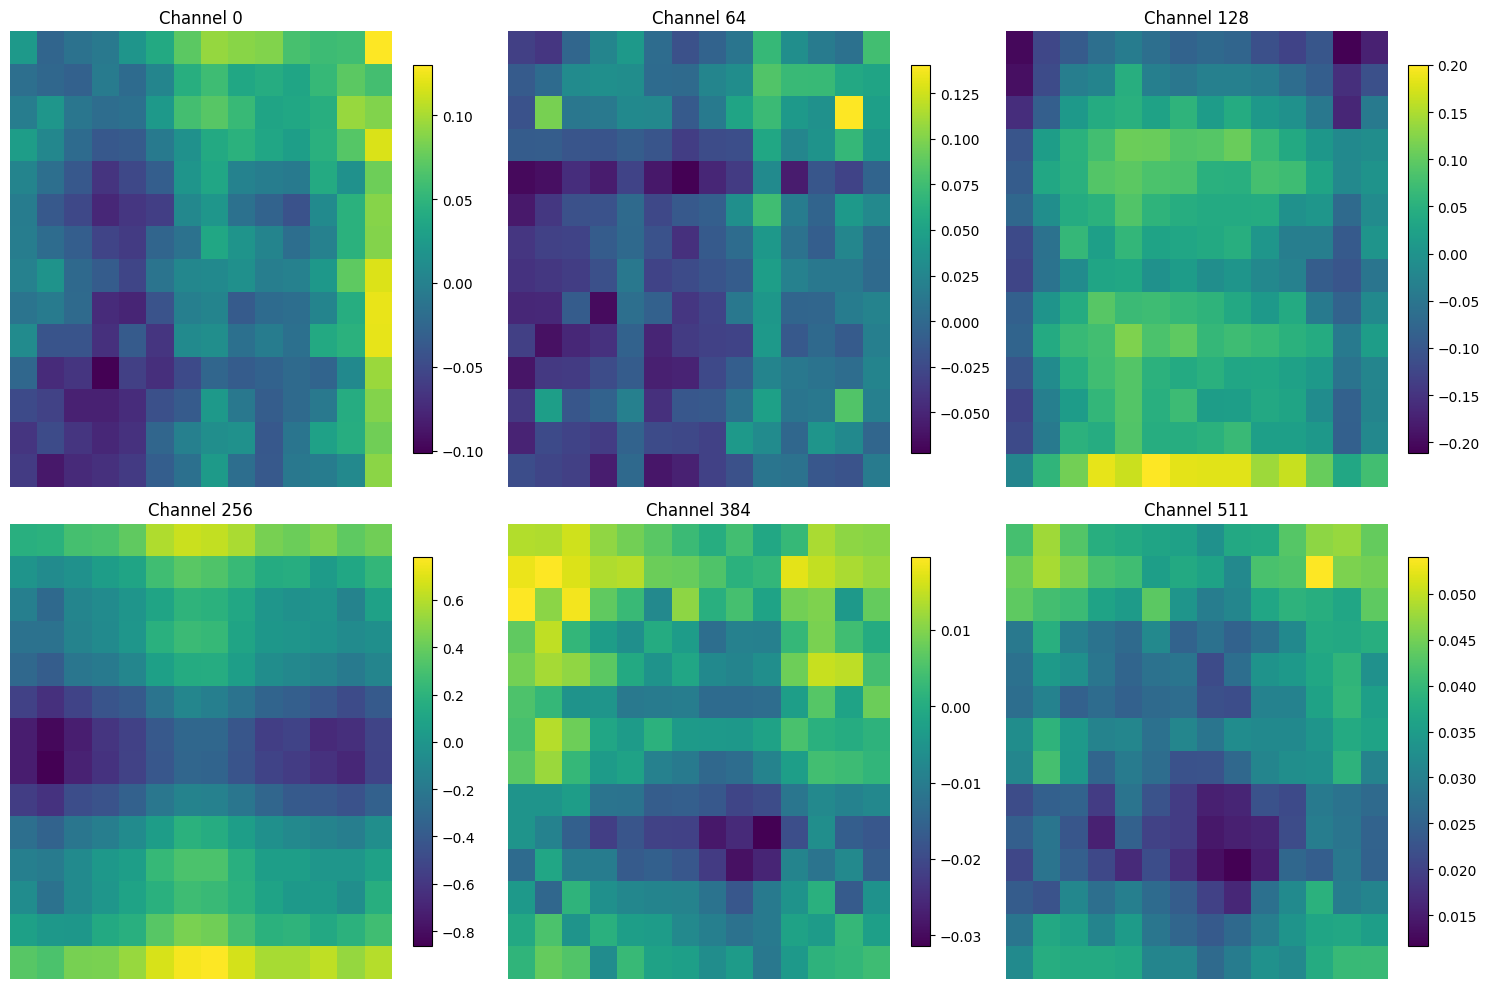

In [3]:
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
vit_model = vit_model.to(device)
vit_model.eval()

pos_embed = vit_model.pos_embed
print(f"Positional embedding shape: {pos_embed.shape}")

num_patches_h = num_patches_w = 14
patch_size = 16

pos_embed_2d = pos_embed[0, 1:, :].reshape(num_patches_h, num_patches_w, -1).detach().cpu().numpy()

print(f"Reshaped positional embedding shape: {pos_embed_2d.shape}")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

channels_to_show = [0, 64, 128, 256, 384, 511]

for idx, channel in enumerate(channels_to_show):
    if channel < pos_embed_2d.shape[2]:
        pos_channel = pos_embed_2d[:, :, channel]
        im = axes[idx].imshow(pos_channel, cmap='viridis', aspect='auto')
        axes[idx].set_title(f'Channel {channel}')
        axes[idx].axis('off')
        plt.colorbar(im, ax=axes[idx], fraction=0.046)

plt.tight_layout()
plt.show()


## Дообучение головы классификации

Дообучаем голову классификации на train датасете перед оценкой на разных разрешениях.


In [ ]:
def finetune_classifier_head(model, train_loader, device, epochs=5, lr=0.001):
    for param in model.parameters():
        param.requires_grad = False
    
    classifier_module = None
    if hasattr(model, 'head'):
        classifier_module = model.head
    elif hasattr(model, 'fc'):
        classifier_module = model.fc
    elif hasattr(model, 'classifier'):
        classifier_module = model.classifier
    else:
        for name, module in model.named_modules():
            if 'head' in name.lower() or 'classifier' in name.lower() or 'fc' in name.lower():
                classifier_module = module
                break
    
    if classifier_module is None:
        print("Warning: Could not find classifier head, training all parameters")
        for param in model.parameters():
            param.requires_grad = True
    else:
        print(f"Found classifier module: {classifier_module}")
        for param in classifier_module.parameters():
            param.requires_grad = True
    
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    if len(trainable_params) == 0:
        raise ValueError("No trainable parameters found!")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(trainable_params, lr=lr)
    
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    
    model.eval()
    return model

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

print("Finetuning ViT classifier head...")
vit_model = finetune_classifier_head(vit_model, train_loader, device, epochs=5, lr=0.001)

print("\nFinetuning Swin classifier head...")
swin_model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=num_classes)
swin_model = swin_model.to(device)
swin_model = finetune_classifier_head(swin_model, train_loader, device, epochs=5, lr=0.001)


Finetuning ViT classifier head...
Found classifier module: Linear(in_features=768, out_features=200, bias=True)


Epoch 1/5, Loss: 0.5816


Epoch 2/5, Loss: 0.3541


Epoch 3/5, Loss: 0.2688


Epoch 4/5:  53%|█████▎    | 1655/3125 [01:42<01:31, 16.11it/s]

## Изменение разрешения с корректной интерполяцией позиций

Тестируем дообученный ViT на разных разрешениях с правильной 2D интерполяцией позиционных эмбеддингов.


In [ ]:
def interpolate_pos_embed(pos_embed, new_size):
    pos_embed = pos_embed.unsqueeze(0)
    
    cls_token = pos_embed[:, :1, :]
    pos_tokens = pos_embed[:, 1:, :]
    
    old_size = int(np.sqrt(pos_tokens.shape[1]))
    pos_tokens = pos_tokens.reshape(1, old_size, old_size, -1).permute(0, 3, 1, 2)
    
    pos_tokens = F.interpolate(pos_tokens, size=(new_size, new_size), mode='bilinear', align_corners=False)
    
    pos_tokens = pos_tokens.permute(0, 2, 3, 1).reshape(1, new_size * new_size, -1)
    
    new_pos_embed = torch.cat([cls_token, pos_tokens], dim=1)
    
    return new_pos_embed.squeeze(0)

def get_classifier_module(model):
    if hasattr(model, 'head'):
        return model.head
    elif hasattr(model, 'fc'):
        return model.fc
    elif hasattr(model, 'classifier'):
        return model.classifier
    else:
        for name, module in model.named_modules():
            if 'head' in name.lower() or 'classifier' in name.lower() or 'fc' in name.lower():
                return module
    return None

def evaluate_vit_at_resolution(model, val_loader, resolution, device):
    model_copy = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
    
    classifier_src = get_classifier_module(model)
    classifier_dst = get_classifier_module(model_copy)
    
    if classifier_src is not None and classifier_dst is not None:
        classifier_dst.load_state_dict(classifier_src.state_dict())
    
    model_copy = model_copy.to(device)
    model_copy.eval()
    
    new_num_patches = resolution // 16
    new_pos_embed = interpolate_pos_embed(model_copy.pos_embed, new_num_patches)
    model_copy.pos_embed = nn.Parameter(new_pos_embed)
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Evaluating at {resolution}x{resolution}", leave=False):
            images = F.interpolate(images, size=(resolution, resolution), mode='bilinear', align_corners=False)
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model_copy(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

resolutions = [224, 256, 288, 320]
vit_accuracies = []

val_dataset_base = TinyImageNetValDataset(
    val_dir=os.path.join(data_dir, 'val'),
    val_annotations_file=os.path.join(data_dir, 'val', 'val_annotations.txt'),
    class_to_idx=train_dataset.class_to_idx,
    transform=transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
)

for res in resolutions:
    val_dataset = TinyImageNetValDataset(
        val_dir=os.path.join(data_dir, 'val'),
        val_annotations_file=os.path.join(data_dir, 'val', 'val_annotations.txt'),
        class_to_idx=train_dataset.class_to_idx,
        transform=transforms.Compose([transforms.Resize((res, res)), transforms.ToTensor()])
    )
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
    
    acc = evaluate_vit_at_resolution(vit_model, val_loader, res, device)
    vit_accuracies.append(acc)
    print(f"Resolution {res}x{res}: {acc:.2f}%")

print("\nViT Accuracies:")
for res, acc in zip(resolutions, vit_accuracies):
    print(f"  {res}x{res}: {acc:.2f}%")


### Ошибка интерполяции

Показываем падение качества при неправильной интерполяции позиционных эмбеддингов (1D интерполяция вместо 2D).


In [ ]:
def interpolate_pos_embed_wrong(pos_embed, new_size):
    pos_embed = pos_embed.unsqueeze(0)
    
    cls_token = pos_embed[:, :1, :]
    pos_tokens = pos_embed[:, 1:, :]
    
    old_size = int(np.sqrt(pos_tokens.shape[1]))
    new_num_tokens = new_size * new_size
    
    pos_tokens = F.interpolate(pos_tokens.permute(0, 2, 1), size=new_num_tokens, mode='linear', align_corners=False)
    pos_tokens = pos_tokens.permute(0, 2, 1)
    
    new_pos_embed = torch.cat([cls_token, pos_tokens], dim=1)
    
    return new_pos_embed.squeeze(0)

def evaluate_vit_wrong_interpolation(model, val_loader, resolution, device):
    model_copy = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
    
    classifier_src = get_classifier_module(model)
    classifier_dst = get_classifier_module(model_copy)
    
    if classifier_src is not None and classifier_dst is not None:
        classifier_dst.load_state_dict(classifier_src.state_dict())
    
    model_copy = model_copy.to(device)
    model_copy.eval()
    
    new_num_patches = resolution // 16
    new_pos_embed = interpolate_pos_embed_wrong(model_copy.pos_embed, new_num_patches)
    model_copy.pos_embed = nn.Parameter(new_pos_embed)
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Wrong interpolation at {resolution}x{resolution}", leave=False):
            images = F.interpolate(images, size=(resolution, resolution), mode='bilinear', align_corners=False)
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model_copy(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

vit_accuracies_wrong = []

for res in resolutions:
    val_dataset = TinyImageNetValDataset(
        val_dir=os.path.join(data_dir, 'val'),
        val_annotations_file=os.path.join(data_dir, 'val', 'val_annotations.txt'),
        class_to_idx=train_dataset.class_to_idx,
        transform=transforms.Compose([transforms.Resize((res, res)), transforms.ToTensor()])
    )
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
    
    acc = evaluate_vit_wrong_interpolation(vit_model, val_loader, res, device)
    vit_accuracies_wrong.append(acc)
    print(f"Resolution {res}x{res} (wrong interpolation): {acc:.2f}%")

print("\nViT Accuracies (wrong interpolation):")
for res, acc in zip(resolutions, vit_accuracies_wrong):
    print(f"  {res}x{res}: {acc:.2f}%")


## Swin Transformer: Relative Position Bias

Тестируем Swin Transformer с Relative Position Bias, который не требует интерполяции при изменении разрешения.


In [ ]:
def evaluate_swin_at_resolution(model, val_loader, resolution, device):
    model_copy = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=num_classes)
    
    classifier_src = get_classifier_module(model)
    classifier_dst = get_classifier_module(model_copy)
    
    if classifier_src is not None and classifier_dst is not None:
        classifier_dst.load_state_dict(classifier_src.state_dict())
    
    model_copy = model_copy.to(device)
    model_copy.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Swin at {resolution}x{resolution}", leave=False):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model_copy(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

swin_accuracies = []

for res in resolutions:
    val_dataset = TinyImageNetValDataset(
        val_dir=os.path.join(data_dir, 'val'),
        val_annotations_file=os.path.join(data_dir, 'val', 'val_annotations.txt'),
        class_to_idx=train_dataset.class_to_idx,
        transform=transforms.Compose([transforms.Resize((res, res)), transforms.ToTensor()])
    )
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
    
    acc = evaluate_swin_at_resolution(swin_model, val_loader, res, device)
    swin_accuracies.append(acc)
    print(f"Resolution {res}x{res}: {acc:.2f}%")

print("\nSwin Accuracies:")
for res, acc in zip(resolutions, swin_accuracies):
    print(f"  {res}x{res}: {acc:.2f}%")


## Сравнение ViT vs Swin: Accuracy и Latency

Сравниваем точность и скорость инференса ViT и Swin на разных разрешениях.


In [ ]:
def measure_latency(model, input_size, device, num_iterations=100):
    model.eval()
    dummy_input = torch.randn(1, 3, input_size, input_size).to(device)
    
    if device.type == 'cuda':
        torch.cuda.synchronize()
    
    start_time = time.time()
    
    with torch.no_grad():
        for _ in range(num_iterations):
            _ = model(dummy_input)
    
    if device.type == 'cuda':
        torch.cuda.synchronize()
    
    end_time = time.time()
    avg_time = (end_time - start_time) / num_iterations
    
    return avg_time * 1000

vit_latencies = []
swin_latencies = []

vit_model_final = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
vit_model_final = vit_model_final.to(device)

swin_model_final = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=num_classes)
swin_model_final = swin_model_final.to(device)

for res in resolutions:
    vit_lat = measure_latency(vit_model_final, res, device)
    swin_lat = measure_latency(swin_model_final, res, device)
    
    vit_latencies.append(vit_lat)
    swin_latencies.append(swin_lat)
    
    print(f"Resolution {res}x{res}:")
    print(f"  ViT latency: {vit_lat:.2f} ms")
    print(f"  Swin latency: {swin_lat:.2f} ms")


### Визуализация результатов

Строим графики accuracy vs input size и сравниваем ViT и Swin.


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(resolutions, vit_accuracies, 'o-', label='ViT (correct interpolation)', linewidth=2, markersize=8)
axes[0].plot(resolutions, vit_accuracies_wrong, 's--', label='ViT (wrong interpolation)', linewidth=2, markersize=8)
axes[0].plot(resolutions, swin_accuracies, '^-', label='Swin (RPB)', linewidth=2, markersize=8)
axes[0].set_xlabel('Input Resolution', fontsize=12)
axes[0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0].set_title('Accuracy vs Input Resolution', fontsize=14)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(resolutions)

axes[1].plot(resolutions, vit_latencies, 'o-', label='ViT', linewidth=2, markersize=8)
axes[1].plot(resolutions, swin_latencies, '^-', label='Swin', linewidth=2, markersize=8)
axes[1].set_xlabel('Input Resolution', fontsize=12)
axes[1].set_ylabel('Latency (ms)', fontsize=12)
axes[1].set_title('Latency vs Input Resolution', fontsize=14)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(resolutions)

plt.tight_layout()
plt.show()


### Таблица сравнения ViT vs Swin

Создаём таблицу с результатами сравнения.


In [ ]:
import pandas as pd

results_data = {
    'Resolution': resolutions,
    'ViT Accuracy (%)': [f"{acc:.2f}" for acc in vit_accuracies],
    'ViT Wrong Interp (%)': [f"{acc:.2f}" for acc in vit_accuracies_wrong],
    'Swin Accuracy (%)': [f"{acc:.2f}" for acc in swin_accuracies],
    'ViT Latency (ms)': [f"{lat:.2f}" for lat in vit_latencies],
    'Swin Latency (ms)': [f"{lat:.2f}" for lat in swin_latencies],
}

df_results = pd.DataFrame(results_data)

print("="*80)
print("Comparison: ViT vs Swin")
print("="*80)
print(df_results.to_string(index=False))
print("="*80)

fig, ax = plt.subplots(figsize=(14, 6))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=df_results.values,
                 colLabels=df_results.columns,
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

for i in range(len(df_results.columns)):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

plt.title('ViT vs Swin: Accuracy and Latency Comparison', fontsize=14, pad=20)
plt.show()
